  # <center> Taller 2 - Topicos en aprendizaje de Máquinas </center>
## <center>Samuel Suárez 202221595 </center>

## Setup inicial
Instalamos e importamos los paquetes usados en el proyecto y creamos los datos con forma de luna, que buscaremos usar para predicción haciendo uso de un Random Forest.

### Importamos paquetes

In [48]:
# Puede ser necesario instalar scikit-learn y matplotlib en una celda de código separada con los comandos:
# pip install -U scikit-learn
# pip install -U matplotlib
# pip install -U pandas
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd


### Creamos los datos

In [49]:
# Creamos los datos
X, y = make_moons(n_samples= 1000, random_state = 888, noise = 0.2)

## Exploración de datos
Iniciamos viendo la estructura de la base de datos.

### Estructura

In [50]:
# Miramos los datos
print("Algunos de los datos en x se ven así")
print(X[:10, ])
print("")

print("Algunos de los datos en y se ven así")
print(y[:10])
print("")

# Miramos las proporciones de la clase objetivo
print("")
print(f"Las clases para 'y' se dividen en {np.sum(y)*100/len(y)}% de los datos para una clase y {100-np.sum(y)*100/len(y)}% para la otra clase")

Algunos de los datos en x se ven así
[[ 0.57925087 -0.43900292]
 [ 1.7410703   0.41655357]
 [ 2.16670204  0.28401191]
 [ 0.03747799  1.31372085]
 [ 0.08191925  1.21323957]
 [-1.22405263  0.92110719]
 [ 0.94018675 -0.13779717]
 [ 0.6545524   0.64399088]
 [-0.75625927  0.28222399]
 [-0.52831931  0.50104647]]

Algunos de los datos en y se ven así
[1 1 1 0 0 0 1 0 0 1]


Las clases para 'y' se dividen en 50.0% de los datos para una clase y 50.0% para la otra clase


Note que la base de datos contiene dos variables explicativas y una variable explicada con clases balanceadas. A continuación procedemos a graficar la base de datos, usando las dos variables de los datos creados.

### Grafica de los datos

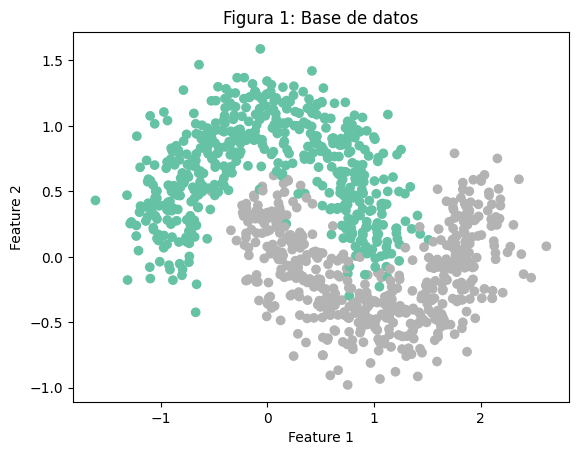

In [51]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set2')
plt.title("Figura 1: Base de datos")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Separación de datos
A continuación procedemos a separar los datos en datos de entrenamiento, prueba y validación.

In [52]:
# Separamos los datos con un split de 70% para entrenamiento y 30% para prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=888, test_size=0.3)

## Frontera de decisión
Antes de analizar el compromiso entre sesgo y varianza, visualizamos la frontera de decisión aprendida por un árbol de decisión ajustado sobre todos los datos. Esto ayuda a determinar el buen funcionamiento del modelo.

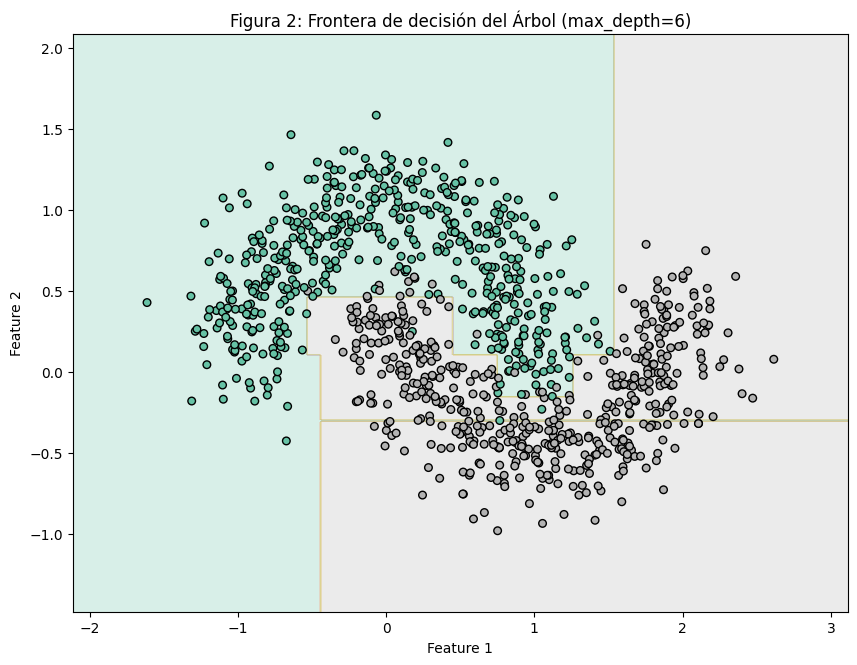

In [53]:
# Figura 2: Frontera de decisión del árbol de decisión

arbol_frontera = DTC(criterion='entropy', max_depth=6, random_state=4)
arbol_frontera.fit(X, y)

x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x0_min, x0_max, 400),
    np.linspace(x1_min, x1_max, 400)
)

Z = arbol_frontera.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7.5))
plt.contourf(xx, yy, Z, alpha=0.25, cmap='Set2')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set2', edgecolor='k', s=30)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Figura 2: Frontera de decisión del Árbol (max_depth=6)')
plt.show()

Se usó la profundidad óptima, encontrada más adelante. Note que el modelo clasifica de forma adecuada, incluso considerando la complejidad no lineal de los datos. Vale la pena notar que las fronteras creadas por el modelo no son redondas y continuas, como los datos podrían sugerir. Sin embargo, estas fronteras se aproximan a los datos y evitan sobreajustes.

## El compromiso entre sesgo y varianza en un arbol de decisión
A continuación, buscaremos iterar por arboles de decisión de distintas profundidades para ver cómo la profundidad puede aumentar la complejidad de nuestro arbol de decisión, mostrando así el compromiso que hay entre sesgo y varianza.

In [54]:
# Crear un loop (for) para validar el resultado en accuracy para distintos k. Guardar los resultados en entrenamiento y prueba
train_scores = []
test_scores = []

profundidad = np.arange(1, 16, 1)

for d in profundidad:
    arbol = DTC(criterion='entropy',
    max_depth = d,
    random_state = 4)
    arbol.fit(X, y)
    arbol.fit(x_train, y_train)
    train_scores.append(1-accuracy_score(y_train, arbol.predict(x_train)))
    test_scores.append(1- accuracy_score(y_test, arbol.predict(x_test)))

train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)

n_train = len(y_train)
n_test = len(y_test)

# Añadimos calculos para los intervalos de confianza
train_margin = 1.96 * np.sqrt((train_scores_np * (1 - train_scores_np)) / n_train)
test_margin = 1.96 * np.sqrt((test_scores_np * (1 - test_scores_np)) / n_test)

train_ci_lower = np.clip(train_scores_np - train_margin, 0, 1)
train_ci_upper = np.clip(train_scores_np + train_margin, 0, 1)

test_ci_lower = np.clip(test_scores_np - test_margin, 0, 1)
test_ci_upper = np.clip(test_scores_np + test_margin, 0, 1)

# Mostramos los resultados
df = pd.DataFrame({
    'Profundidad': profundidad,
    'Error en entrenamiento': train_scores,
    'Error en prueba': test_scores,
    'IC95 entrenamiento inferior': train_ci_lower,
    'IC95 entrenamiento superior': train_ci_upper,
    'IC95 prueba inferior': test_ci_lower,
    'IC95 prueba superior': test_ci_upper
})

df

,Profundidad,Error en entrenamiento,Error en prueba,IC95 entrenamiento inferior,IC95 entrenamiento superior,IC95 prueba inferior,IC95 prueba superior
0,1,0.155714,0.203333,0.128854,0.182575,0.157789,0.248878
1,2,0.081429,0.113333,0.061168,0.101689,0.077461,0.149205
2,3,0.081429,0.113333,0.061168,0.101689,0.077461,0.149205
3,4,0.081429,0.113333,0.061168,0.101689,0.077461,0.149205
4,5,0.022857,0.033333,0.011786,0.033928,0.013020,0.053646
5,6,0.015714,0.030000,0.006501,0.024928,0.010696,0.049304
6,7,0.011429,0.036667,0.003554,0.019303,0.015399,0.057934
7,8,0.010000,0.040000,0.002629,0.017371,0.017825,0.062175
8,9,0.007143,0.040000,0.000904,0.013381,0.017825,0.062175
9,10,0.005714,0.043333,0.000130,0.011298,0.020293,0.066374


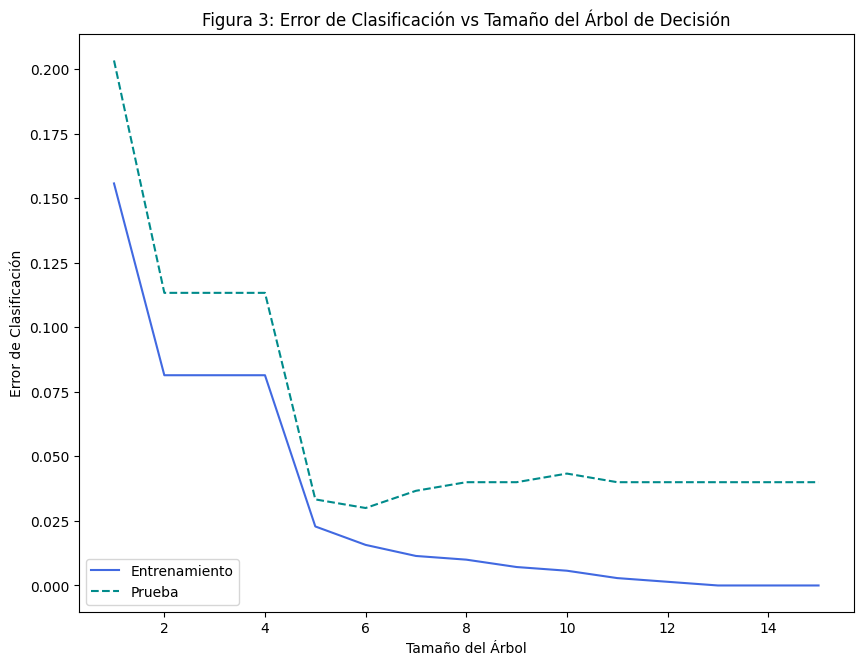

depth óptimo en prueba: 6


In [55]:
# Graficamos los resultados del loop

plt.figure(figsize=(10,7.5))
plt.plot(df['Profundidad'], df['Error en entrenamiento'], c="royalblue", label="Entrenamiento")
plt.plot(df['Profundidad'], df['Error en prueba'], c="darkcyan", linestyle="--", label="Prueba")
plt.xlabel('Tamaño del Árbol')
plt.ylabel('Error de Clasificación')
plt.title('Figura 3: Error de Clasificación vs Tamaño del Árbol de Decisión')
plt.legend(loc = "lower left")
plt.show()

# Buscamos el depth óptimo en prueba

min_value = df['Error en prueba'].min()
min_index = df['Error en prueba'].idxmin()
print("depth óptimo en prueba:", df['Profundidad'][min_index])

Vemos en nuestra figura cómo el error de clasificación varía con el tamaño del árbol de decisión, reflejando el compromiso entre sesgo y varianza. Cuando el árbol es muy pequeño, tanto el error de entrenamiento como el de prueba son altos porque el modelo es demasiado simple y presenta alto sesgo (subajuste). A medida que el árbol crece, el error de entrenamiento disminuye casi a cero, pero el error de prueba deja de mejorar y se estabiliza, lo cual sugiere que el modelo esta en un sobreajuste a los datos de entrenamiento, lo cual hará que aumente la varianza. El punto óptimo está en un tamaño intermedio el cual parece ser alrededor de una profundidad de 6.

# Cross Validation e Intervalos de Confianza
Ahora buscamos añadir una prueba de valicación cruzada a la gráfica, lo cual nos dará más información sobre el compromiso entre sesgo y varianza. Añadimos también intervalos de confianza para crear la versión final de nuestra gráfica.

In [56]:
# Cross-validation para cada profundidad en el árbol (error de clasificación)

cv_error_means = []
cv_error_stds = []
cv_ci_low = []
cv_ci_high = []

n_folds = 10
for d in profundidad:
    arbol_cv = DTC(
        criterion='entropy',
        max_depth=d,
        random_state=888
    )

    # Añadimos calculos para los intervalos de confianza
    scores = cross_val_score(arbol_cv, X, y, cv=n_folds)
    error_scores = 1 - scores
    mean_error = np.mean(error_scores)
    std_error = np.std(error_scores, ddof=1)
    margin = 1.96 * std_error / np.sqrt(n_folds)

    cv_error_means.append(mean_error)
    cv_error_stds.append(std_error)
    cv_ci_low.append(mean_error - margin)
    cv_ci_high.append(mean_error + margin)

cv_df = pd.DataFrame({
    'Profundidad': profundidad,
    'Error promedio (CV)': cv_error_means,
    'Desviación estándar': cv_error_stds,
    'IC95 inferior': cv_ci_low,
    'IC95 superior': cv_ci_high
})

cv_df

,Profundidad,Error promedio (CV),Desviación estándar,IC95 inferior,IC95 superior
0,1,0.196,0.030623,0.177020,0.214980
1,2,0.108,0.028597,0.090276,0.125724
2,3,0.108,0.028597,0.090276,0.125724
3,4,0.108,0.028597,0.090276,0.125724
4,5,0.040,0.016997,0.029465,0.050535
5,6,0.033,0.010593,0.026434,0.039566
6,7,0.038,0.017512,0.027146,0.048854
7,8,0.040,0.023570,0.025391,0.054609
8,9,0.038,0.019889,0.025673,0.050327
9,10,0.039,0.021318,0.025787,0.052213


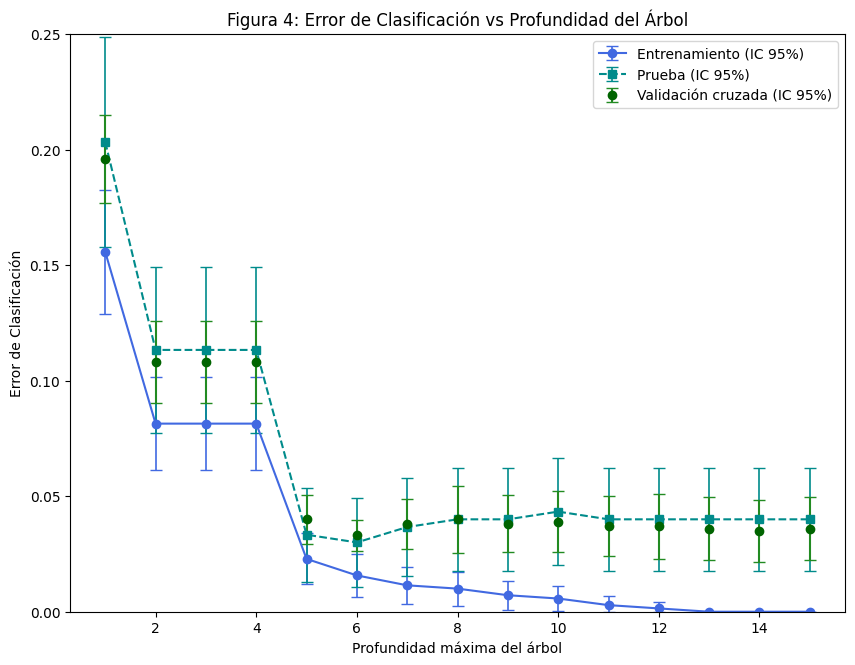

In [57]:
# Graficamos los resultados finales ahora con intervalos de confianza

#Los intervalos son del 95%

plt.figure(figsize=(10, 7.5))

train_yerr = np.vstack((
    df['Error en entrenamiento'] - df['IC95 entrenamiento inferior'],
    df['IC95 entrenamiento superior'] - df['Error en entrenamiento']
))
plt.errorbar(
    df['Profundidad'],
    df['Error en entrenamiento'],
    yerr=train_yerr,
    fmt='o-',
    color='royalblue',
    ecolor='royalblue',
    elinewidth=1.2,
    capsize=4,
    label='Entrenamiento (IC 95%)'
)

test_yerr = np.vstack((
    df['Error en prueba'] - df['IC95 prueba inferior'],
    df['IC95 prueba superior'] - df['Error en prueba']
))
plt.errorbar(
    df['Profundidad'],
    df['Error en prueba'],
    yerr=test_yerr,
    fmt='s--',
    color='darkcyan',
    ecolor='darkcyan',
    elinewidth=1.2,
    capsize=4,
    label='Prueba (IC 95%)'
)

cv_yerr = np.vstack((
    cv_df['Error promedio (CV)'] - cv_df['IC95 inferior'],
    cv_df['IC95 superior'] - cv_df['Error promedio (CV)']
))
plt.errorbar(
    cv_df['Profundidad'],
    cv_df['Error promedio (CV)'],
    yerr=cv_yerr,
    fmt='o',
    color='darkgreen',
    ecolor='forestgreen',
    elinewidth=1.5,
    capsize=4,
    label='Validación cruzada (IC 95%)'
)

plt.xlabel('Profundidad máxima del árbol')
plt.ylabel('Error de Clasificación')
plt.title('Figura 4: Error de Clasificación vs Profundidad del Árbol')
plt.ylim(0, 0.25)
plt.legend(loc='upper right')
plt.show()

Vemos en la figura 4, cómo el error de clasificación varía con la profundidad máxima del árbol de decisión, reflejando  el compromiso entre sesgo y varianza. Cuando el árbol es muy poco profundo, tanto el error de entrenamiento como el de prueba y validación son altos, lo que indica que el modelo es demasiado simple y presenta un alto sesgo (subajuste). A medida que la profundidad aumenta, el error de entrenamiento disminuye de forma rápida y llega casi a cero, mientras que el error de prueba y validación cruzada dejan de mejorar a partir de una profundidad intermedia y se estabilizan, señalando que el modelo comienza a sobreajustarse a los datos de entrenamiento. El punto óptimo de complejidad parece encontrarse alrededor de una profundidad de 6, donde se logra el mejor balance entre bajo error y estabilidad predictiva.
